### Introduction

Personality traits like extroversion and introversion shape how individuals interact with their social environments. This dataset provides insights into behaviors such as time spent alone, social event attendance, and social media engagement, enabling applications in psychology, sociology, marketing, and machine learning

In [21]:
# Suppress warning for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Data Manipulations and analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - model selction and preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Machine learning - evaluation metrics
from sklearn.metrics import accuracy_score, log_loss

import xgboost as xgb

import optuna
from optuna.samplers import TPESampler


In [ ]:
class CFG:
    # File paths
    train_path = '../_data/pgseries-s05e07/train.csv'
    test_path = '../_data/pgseries-s05e07/test.csv'
    sub_path = '../_data/pgseries-s05e07/sample_submission.csv'
    
    # Model configuration
    target = 'Personality'  # Binary classification: Introvert vs Extrovert
    n_folds = 5            # Cross-validation folds
    seed = 42              # For reproducibility
    cv = StratifiedKFold(n_splits=n_folds, random_state=seed, shuffle=True)
    # Ensure each fold has same class dist as whole dataset, Shuffles data
    metric = accuracy_score     
    n_optuna_trials = 500  # Hyperparameter optimization trials

# Load data with 'id' as index
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')
submissions = pd.read_csv(CFG.sub_path, index_col='id')


Training samples: 18524
Features: 7
Target classes: 2


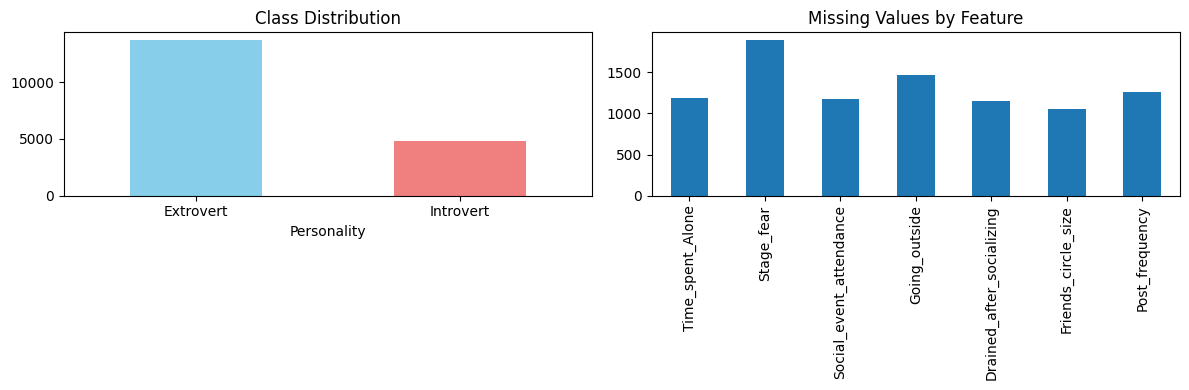

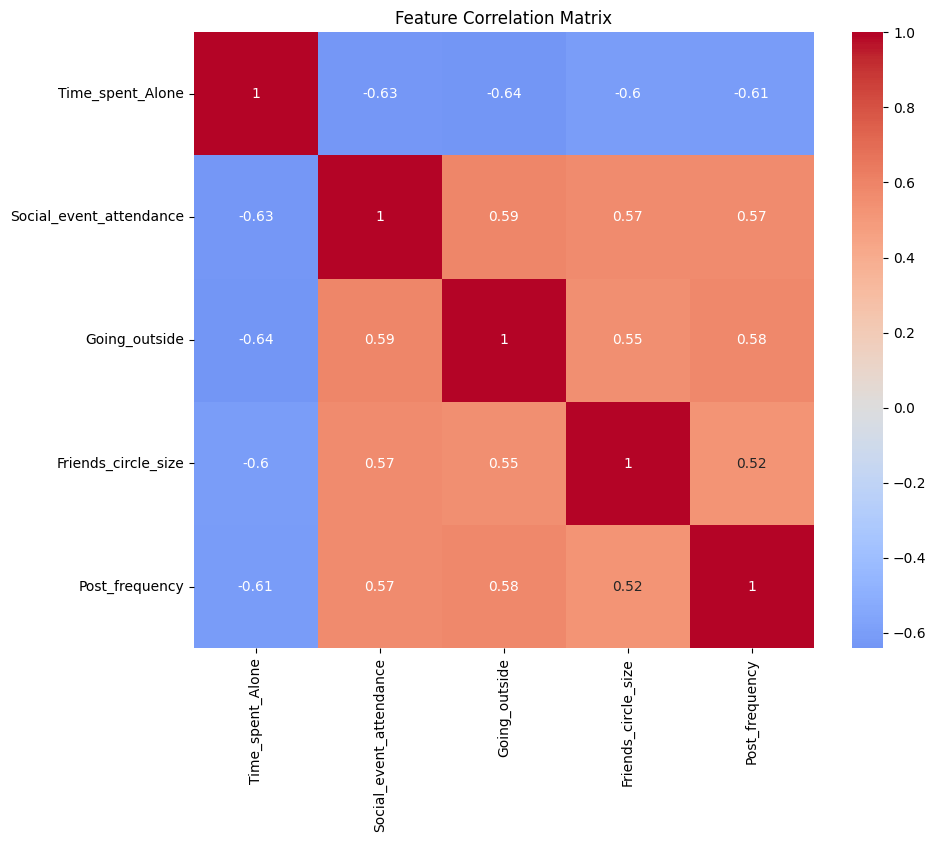

In [ ]:
def comprehensive_eda(train_df, target_col='Personality'):
    """Perform comprehensive EDA to understand data patterns"""

    print(f"Training samples: {len(train_df)}")
    print(f"Features: {len(train_df.columns) - 1}")
    print(f"Target classes: {train_df[target_col].nunique()}")
    
    # Class distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1) # (1 row, 2 columns, 1st plot)
    train_df[target_col].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Class Distribution')
    plt.xticks(rotation=0)
    
    # Missing values heatmap
    plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd plot)
    missing_data = train_df.isnull().sum()
    if missing_data.sum() > 0:
        missing_data[missing_data > 0].plot(kind='bar')
        plt.title('Missing Values by Feature')
    else:
        plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=14)
        plt.title('Missing Values Check')
    
    plt.tight_layout()
    plt.show()
    
    # Feature correlations with target
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8)) # figure means 10 inches by 8 inches
        correlation_matrix = train_df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

# Apply enhanced EDA
comprehensive_eda(train)


In [20]:
# Advanced Preprocessing Pipeline
def create_advanced_preprocessor(numeric_features, categorical_features, n_features=None):
    """Create preprocessing pipeline"""
    
    # Numeric preprocessing with scaling
    numeric_transformer = Pipeline([
        ('scaler', RobustScaler()),  # More robust to outliers than StandardScaler
    ])
     # for each feature -> scaled_x = (x - median) / IQR
    
    # Categorical preprocessing
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    # for each feature -> one-hot encoding. 
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
    return preprocessor

# Enhanced target encoding and feature preparation
le = LabelEncoder()
train["Personality_encoded"] = le.fit_transform(train["Personality"])

# Prepare features
X_train = train.drop(columns=["Personality", "Personality_encoded"])
y_train = train["Personality_encoded"]
X_test = test.copy()

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Create advanced preprocessor
advanced_preprocessor = create_advanced_preprocessor(numeric_features, categorical_features)

# Apply preprocessing
X_preprocessed_advanced = advanced_preprocessor.fit_transform(X_train)
X_test_preprocessed_advanced = advanced_preprocessor.transform(X_test)

print(f"Final feature shape: {X_preprocessed_advanced.shape}")

Numeric features: 5
Categorical features: 2
Final feature shape: (18524, 11)


In [ ]:
# Optuna hyperparameter optimization for XGBoost
def objective(trial):
    """Optuna objective function for hyperparameter optimization"""
    
    # Suggest hyperparameters
    params = {
        'objective': 'binary:logistic', #output probabilities for binary classification
        'eval_metric': 'logloss', 
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'verbosity': 0
    }
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_preprocessed_advanced, y_train)):
        X_train_fold = X_preprocessed_advanced[train_idx]
        X_val_fold = X_preprocessed_advanced[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        
        model = xgb.train(
            params, dtrain,
            num_boost_round=200,
            evals=[(dval, 'valid')],
            early_stopping_rounds=20,
            verbose_eval=False
        )
        
        preds = model.predict(dval)
        score = accuracy_score(y_val_fold, preds > 0.5)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

# Run hyperparameter optimization
print("🚀 Starting Hyperparameter Optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"Best CV Score: {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Use best parameters
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'verbosity': 0
})

[I 2025-07-30 19:43:09,751] A new study created in memory with name: no-name-b4c8470c-5137-448d-a04d-f79bc1bf69ac


🚀 Starting Hyperparameter Optimization...


Best trial: 0. Best value: 0.968635:   1%|          | 1/100 [00:00<00:53,  1.85it/s]

[I 2025-07-30 19:43:10,299] Trial 0 finished with value: 0.9686354176686109 and parameters: {'max_depth': 5, 'eta': 0.28570714885887566, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'min_child_weight': 2, 'gamma': 0.7799726016810132, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.9686354176686109.


Best trial: 1. Best value: 0.968959:   2%|▏         | 2/100 [00:01<00:54,  1.79it/s]

[I 2025-07-30 19:43:10,873] Trial 1 finished with value: 0.9689592751608211 and parameters: {'max_depth': 7, 'eta': 0.21534104756085318, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'min_child_weight': 9, 'gamma': 1.0616955533913808, 'reg_alpha': 0.9091248360355031, 'reg_lambda': 0.9170225492671691}. Best is trial 1 with value: 0.9689592751608211.


Best trial: 2. Best value: 0.969121:   3%|▎         | 3/100 [00:01<00:54,  1.78it/s]

[I 2025-07-30 19:43:11,436] Trial 2 finished with value: 0.9691212767755907 and parameters: {'max_depth': 5, 'eta': 0.16217936517334897, 'subsample': 0.7727780074568463, 'colsample_bytree': 0.7164916560792167, 'min_child_weight': 7, 'gamma': 0.6974693032602092, 'reg_alpha': 1.4607232426760908, 'reg_lambda': 1.8318092164684585}. Best is trial 2 with value: 0.9691212767755907.


Best trial: 2. Best value: 0.969121:   4%|▍         | 4/100 [00:02<00:51,  1.85it/s]

[I 2025-07-30 19:43:11,944] Trial 3 finished with value: 0.9690133145623653 and parameters: {'max_depth': 6, 'eta': 0.23770102880397392, 'subsample': 0.6798695128633439, 'colsample_bytree': 0.8056937753654446, 'min_child_weight': 6, 'gamma': 0.23225206359998862, 'reg_alpha': 3.0377242595071916, 'reg_lambda': 0.8526206184364576}. Best is trial 2 with value: 0.9691212767755907.


Best trial: 2. Best value: 0.969121:   5%|▌         | 5/100 [00:02<00:48,  1.97it/s]

[I 2025-07-30 19:43:12,392] Trial 4 finished with value: 0.9689592897345541 and parameters: {'max_depth': 3, 'eta': 0.2851768058034666, 'subsample': 0.9862528132298237, 'colsample_bytree': 0.9233589392465844, 'min_child_weight': 4, 'gamma': 0.48836057003191935, 'reg_alpha': 3.4211651325607844, 'reg_lambda': 2.2007624686980067}. Best is trial 2 with value: 0.9691212767755907.


Best trial: 2. Best value: 0.969121:   6%|▌         | 6/100 [00:03<00:47,  1.99it/s]

[I 2025-07-30 19:43:12,884] Trial 5 finished with value: 0.9691212622018579 and parameters: {'max_depth': 3, 'eta': 0.15360130393226834, 'subsample': 0.6137554084460873, 'colsample_bytree': 0.9637281608315128, 'min_child_weight': 3, 'gamma': 3.31261142176991, 'reg_alpha': 1.5585553804470549, 'reg_lambda': 2.600340105889054}. Best is trial 2 with value: 0.9691212767755907.


Best trial: 2. Best value: 0.969121:   7%|▋         | 7/100 [00:03<00:55,  1.68it/s]

[I 2025-07-30 19:43:13,674] Trial 6 finished with value: 0.9687973318409832 and parameters: {'max_depth': 7, 'eta': 0.06360779210240283, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'min_child_weight': 10, 'gamma': 4.474136752138244, 'reg_alpha': 2.9894998940554256, 'reg_lambda': 4.609371175115584}. Best is trial 2 with value: 0.9691212767755907.


Best trial: 7. Best value: 0.969229:   8%|▊         | 8/100 [00:04<01:04,  1.42it/s]

[I 2025-07-30 19:43:14,616] Trial 7 finished with value: 0.9692292098413503 and parameters: {'max_depth': 3, 'eta': 0.0668350301015521, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'min_child_weight': 4, 'gamma': 1.3567451588694794, 'reg_alpha': 4.143687545759647, 'reg_lambda': 1.7837666334679465}. Best is trial 7 with value: 0.9692292098413503.


Best trial: 7. Best value: 0.969229:   9%|▉         | 9/100 [00:05<00:56,  1.60it/s]

[I 2025-07-30 19:43:15,066] Trial 8 finished with value: 0.9690132854148995 and parameters: {'max_depth': 5, 'eta': 0.16738186411589207, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'min_child_weight': 1, 'gamma': 4.9344346830025865, 'reg_alpha': 3.861223846483287, 'reg_lambda': 0.993578407670862}. Best is trial 7 with value: 0.9692292098413503.


Best trial: 9. Best value: 0.969499:  10%|█         | 10/100 [00:05<00:49,  1.84it/s]

[I 2025-07-30 19:43:15,428] Trial 9 finished with value: 0.9694991299481466 and parameters: {'max_depth': 3, 'eta': 0.2464838142519019, 'subsample': 0.8827429375390468, 'colsample_bytree': 0.8916028672163949, 'min_child_weight': 8, 'gamma': 0.3702232586704518, 'reg_alpha': 1.7923286427213632, 'reg_lambda': 0.5793452976256486}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  11%|█         | 11/100 [00:07<01:17,  1.16it/s]

[I 2025-07-30 19:43:17,020] Trial 10 finished with value: 0.9686353739474122 and parameters: {'max_depth': 10, 'eta': 0.011739183057186964, 'subsample': 0.8565821292831765, 'colsample_bytree': 0.6071847502459278, 'min_child_weight': 8, 'gamma': 2.0963905612410483, 'reg_alpha': 4.7988537297270994, 'reg_lambda': 0.05557192411355649}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  12%|█▏        | 12/100 [00:07<01:12,  1.22it/s]

[I 2025-07-30 19:43:17,737] Trial 11 finished with value: 0.9692292244150833 and parameters: {'max_depth': 3, 'eta': 0.09023848265588306, 'subsample': 0.7588192618903339, 'colsample_bytree': 0.7174579338862809, 'min_child_weight': 5, 'gamma': 1.8154358457489121, 'reg_alpha': 2.141458130951058, 'reg_lambda': 3.097669715667996}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  13%|█▎        | 13/100 [00:08<01:09,  1.25it/s]

[I 2025-07-30 19:43:18,485] Trial 12 finished with value: 0.9691212476281251 and parameters: {'max_depth': 4, 'eta': 0.10621729913738301, 'subsample': 0.7604603292118235, 'colsample_bytree': 0.6857486542395244, 'min_child_weight': 6, 'gamma': 2.6388944651501602, 'reg_alpha': 1.9469990906606858, 'reg_lambda': 3.384090290478076}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  14%|█▍        | 14/100 [00:09<01:00,  1.42it/s]

[I 2025-07-30 19:43:18,970] Trial 13 finished with value: 0.9690672519477795 and parameters: {'max_depth': 9, 'eta': 0.22843507426767695, 'subsample': 0.8810516598677163, 'colsample_bytree': 0.8579178144028043, 'min_child_weight': 8, 'gamma': 1.8271302055082885, 'reg_alpha': 2.190650837455672, 'reg_lambda': 3.330344500311682}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  15%|█▌        | 15/100 [00:09<00:57,  1.48it/s]

[I 2025-07-30 19:43:19,573] Trial 14 finished with value: 0.9690132999886325 and parameters: {'max_depth': 4, 'eta': 0.11418940019546708, 'subsample': 0.8213410757087906, 'colsample_bytree': 0.7649121959527431, 'min_child_weight': 5, 'gamma': 2.9239655434348695, 'reg_alpha': 2.6081808519211087, 'reg_lambda': 3.2067931178446263}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  16%|█▌        | 16/100 [00:10<00:52,  1.61it/s]

[I 2025-07-30 19:43:20,079] Trial 15 finished with value: 0.9691752141610049 and parameters: {'max_depth': 8, 'eta': 0.19828640819981877, 'subsample': 0.7246702558066189, 'colsample_bytree': 0.6642576170446484, 'min_child_weight': 7, 'gamma': 3.791118085065369, 'reg_alpha': 0.8566795118864516, 'reg_lambda': 3.9732268205604453}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  17%|█▋        | 17/100 [00:10<00:51,  1.60it/s]

[I 2025-07-30 19:43:20,712] Trial 16 finished with value: 0.9692292535625489 and parameters: {'max_depth': 4, 'eta': 0.11194128085863145, 'subsample': 0.9269175234235232, 'colsample_bytree': 0.7861087915250091, 'min_child_weight': 10, 'gamma': 1.6323830827792802, 'reg_alpha': 0.023700598265445905, 'reg_lambda': 0.04484670740332364}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  18%|█▊        | 18/100 [00:11<00:46,  1.77it/s]

[I 2025-07-30 19:43:21,133] Trial 17 finished with value: 0.9692832492428947 and parameters: {'max_depth': 4, 'eta': 0.2524611162853017, 'subsample': 0.9362148766913249, 'colsample_bytree': 0.8615156286246936, 'min_child_weight': 10, 'gamma': 0.136095131955984, 'reg_alpha': 0.06589607190461777, 'reg_lambda': 0.04611600308429786}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  19%|█▉        | 19/100 [00:11<00:44,  1.81it/s]

[I 2025-07-30 19:43:21,654] Trial 18 finished with value: 0.9691212476281249 and parameters: {'max_depth': 6, 'eta': 0.2517309529509906, 'subsample': 0.9355684562922133, 'colsample_bytree': 0.8743189124742494, 'min_child_weight': 9, 'gamma': 0.3208380879977694, 'reg_alpha': 0.501450230442485, 'reg_lambda': 0.6213990671047201}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  20%|██        | 20/100 [00:12<00:41,  1.93it/s]

[I 2025-07-30 19:43:22,091] Trial 19 finished with value: 0.9691752287347377 and parameters: {'max_depth': 4, 'eta': 0.2697066333879688, 'subsample': 0.8301329499354159, 'colsample_bytree': 0.81311005995684, 'min_child_weight': 9, 'gamma': 0.16604278823317908, 'reg_alpha': 1.3147896615709287, 'reg_lambda': 1.275169895894959}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  21%|██        | 21/100 [00:12<00:40,  1.97it/s]

[I 2025-07-30 19:43:22,573] Trial 20 finished with value: 0.9690672665215121 and parameters: {'max_depth': 5, 'eta': 0.20284102841288645, 'subsample': 0.9298528902087924, 'colsample_bytree': 0.8912734920047153, 'min_child_weight': 8, 'gamma': 1.3000575442978899, 'reg_alpha': 0.859272007344438, 'reg_lambda': 0.3757017681551194}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  22%|██▏       | 22/100 [00:13<00:43,  1.79it/s]

[I 2025-07-30 19:43:23,254] Trial 21 finished with value: 0.9694451925627326 and parameters: {'max_depth': 4, 'eta': 0.13308550780431094, 'subsample': 0.9347350569808327, 'colsample_bytree': 0.7740300092043955, 'min_child_weight': 10, 'gamma': 0.009057000263308856, 'reg_alpha': 0.07510605812843618, 'reg_lambda': 0.2595048216806559}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  23%|██▎       | 23/100 [00:14<00:43,  1.78it/s]

[I 2025-07-30 19:43:23,822] Trial 22 finished with value: 0.9692832055216959 and parameters: {'max_depth': 4, 'eta': 0.18149206365561418, 'subsample': 0.9532799645535306, 'colsample_bytree': 0.8413089627895669, 'min_child_weight': 10, 'gamma': 0.03545827403609686, 'reg_alpha': 0.46104888984901116, 'reg_lambda': 1.3350458085247228}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  24%|██▍       | 24/100 [00:14<00:40,  1.89it/s]

[I 2025-07-30 19:43:24,278] Trial 23 finished with value: 0.9692292389888161 and parameters: {'max_depth': 3, 'eta': 0.24353199109981497, 'subsample': 0.8872604668387544, 'colsample_bytree': 0.7605310311499618, 'min_child_weight': 10, 'gamma': 0.8121146522183671, 'reg_alpha': 1.2544703455469666, 'reg_lambda': 0.3796967855374974}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  25%|██▌       | 25/100 [00:15<00:38,  1.93it/s]

[I 2025-07-30 19:43:24,770] Trial 24 finished with value: 0.9690132854148995 and parameters: {'max_depth': 6, 'eta': 0.2644036331012442, 'subsample': 0.9635117246422013, 'colsample_bytree': 0.965736297669924, 'min_child_weight': 9, 'gamma': 1.0473652413493766, 'reg_alpha': 0.3261666067947113, 'reg_lambda': 0.4731365492284556}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  26%|██▌       | 26/100 [00:15<00:39,  1.85it/s]

[I 2025-07-30 19:43:25,360] Trial 25 finished with value: 0.9691752578822033 and parameters: {'max_depth': 4, 'eta': 0.12901512614686, 'subsample': 0.906511847267412, 'colsample_bytree': 0.831598139690897, 'min_child_weight': 7, 'gamma': 0.536579066387139, 'reg_alpha': 0.11437186052631709, 'reg_lambda': 0.011989449556621068}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  27%|██▋       | 27/100 [00:16<00:40,  1.80it/s]

[I 2025-07-30 19:43:25,954] Trial 26 finished with value: 0.9691212767755907 and parameters: {'max_depth': 5, 'eta': 0.14334379241193218, 'subsample': 0.8533633444868494, 'colsample_bytree': 0.8802384526582789, 'min_child_weight': 8, 'gamma': 0.060340367816840795, 'reg_alpha': 0.727479641156602, 'reg_lambda': 1.4293622708652418}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  28%|██▊       | 28/100 [00:16<00:37,  1.92it/s]

[I 2025-07-30 19:43:26,393] Trial 27 finished with value: 0.9691212330543921 and parameters: {'max_depth': 3, 'eta': 0.18373757472308455, 'subsample': 0.8586500662950346, 'colsample_bytree': 0.9446193503301017, 'min_child_weight': 10, 'gamma': 2.390310897251648, 'reg_alpha': 1.7339005052934993, 'reg_lambda': 0.6809686948950497}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  29%|██▉       | 29/100 [00:17<00:35,  2.03it/s]

[I 2025-07-30 19:43:26,822] Trial 28 finished with value: 0.9692832200954289 and parameters: {'max_depth': 4, 'eta': 0.2116247996226382, 'subsample': 0.9552581033129661, 'colsample_bytree': 0.7808313156209242, 'min_child_weight': 9, 'gamma': 1.1952826801390346, 'reg_alpha': 2.552372825192274, 'reg_lambda': 1.745520638969744}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  30%|███       | 30/100 [00:17<00:35,  2.00it/s]

[I 2025-07-30 19:43:27,341] Trial 29 finished with value: 0.9691212330543921 and parameters: {'max_depth': 5, 'eta': 0.2975069047325109, 'subsample': 0.9066774969307443, 'colsample_bytree': 0.8385706454257669, 'min_child_weight': 9, 'gamma': 0.777684561526653, 'reg_alpha': 1.1289393075541536, 'reg_lambda': 1.095265413414256}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 9. Best value: 0.969499:  31%|███       | 31/100 [00:18<00:36,  1.90it/s]

[I 2025-07-30 19:43:27,930] Trial 30 finished with value: 0.9687973318409832 and parameters: {'max_depth': 8, 'eta': 0.28008004721627455, 'subsample': 0.9940830990281094, 'colsample_bytree': 0.7452490250707723, 'min_child_weight': 8, 'gamma': 0.5005729547132947, 'reg_alpha': 0.5464249256934162, 'reg_lambda': 0.40851178652314046}. Best is trial 9 with value: 0.9694991299481466.


Best trial: 31. Best value: 0.969553:  32%|███▏      | 32/100 [00:18<00:33,  2.01it/s]

[I 2025-07-30 19:43:28,357] Trial 31 finished with value: 0.969553140202225 and parameters: {'max_depth': 4, 'eta': 0.2226560425959507, 'subsample': 0.9539038268565377, 'colsample_bytree': 0.7890830683228455, 'min_child_weight': 9, 'gamma': 1.039976064975408, 'reg_alpha': 2.5464120788944835, 'reg_lambda': 1.5794554241499408}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  33%|███▎      | 33/100 [00:19<00:32,  2.07it/s]

[I 2025-07-30 19:43:28,805] Trial 32 finished with value: 0.9691212476281251 and parameters: {'max_depth': 3, 'eta': 0.25733940039034486, 'subsample': 0.914491637890032, 'colsample_bytree': 0.819229844678846, 'min_child_weight': 10, 'gamma': 0.9499002940685461, 'reg_alpha': 2.830342886311532, 'reg_lambda': 2.437627772785806}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  34%|███▍      | 34/100 [00:19<00:34,  1.91it/s]

[I 2025-07-30 19:43:29,427] Trial 33 finished with value: 0.9692832200954287 and parameters: {'max_depth': 4, 'eta': 0.22585750607040977, 'subsample': 0.9472350478792472, 'colsample_bytree': 0.7934367755381974, 'min_child_weight': 9, 'gamma': 0.3528269471326698, 'reg_alpha': 3.375685356706727, 'reg_lambda': 0.8233085740050347}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  35%|███▌      | 35/100 [00:20<00:44,  1.46it/s]

[I 2025-07-30 19:43:30,483] Trial 34 finished with value: 0.9688513420950615 and parameters: {'max_depth': 5, 'eta': 0.1853441854403428, 'subsample': 0.969985660269489, 'colsample_bytree': 0.9993986750197683, 'min_child_weight': 7, 'gamma': 0.02004882673171693, 'reg_alpha': 2.2165734286742307, 'reg_lambda': 0.2663643722030227}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  36%|███▌      | 36/100 [00:21<00:42,  1.52it/s]

[I 2025-07-30 19:43:31,081] Trial 35 finished with value: 0.9691752287347377 and parameters: {'max_depth': 6, 'eta': 0.2299616271818838, 'subsample': 0.8913735708174501, 'colsample_bytree': 0.6876417350588806, 'min_child_weight': 9, 'gamma': 0.655349633161945, 'reg_alpha': 1.8116238123238042, 'reg_lambda': 1.4410082940925117}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  37%|███▋      | 37/100 [00:21<00:37,  1.69it/s]

[I 2025-07-30 19:43:31,515] Trial 36 finished with value: 0.9690132708411667 and parameters: {'max_depth': 3, 'eta': 0.2946449883828596, 'subsample': 0.7936356912334994, 'colsample_bytree': 0.8957433698319165, 'min_child_weight': 10, 'gamma': 1.5448050485431057, 'reg_alpha': 0.14223241189656433, 'reg_lambda': 1.9770112048984487}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  38%|███▊      | 38/100 [00:22<00:37,  1.66it/s]

[I 2025-07-30 19:43:32,140] Trial 37 finished with value: 0.9689593043082869 and parameters: {'max_depth': 5, 'eta': 0.2750867636352021, 'subsample': 0.8800678900173202, 'colsample_bytree': 0.8615932537987547, 'min_child_weight': 8, 'gamma': 0.39707380694347627, 'reg_alpha': 3.4234954663898027, 'reg_lambda': 0.8346359487374327}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  39%|███▉      | 39/100 [00:23<00:41,  1.48it/s]

[I 2025-07-30 19:43:32,991] Trial 38 finished with value: 0.9690133145623653 and parameters: {'max_depth': 3, 'eta': 0.24622384136348177, 'subsample': 0.9692689282086551, 'colsample_bytree': 0.8538099314723044, 'min_child_weight': 6, 'gamma': 0.8386115819496033, 'reg_alpha': 1.1525639945757473, 'reg_lambda': 1.1118538606462922}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  40%|████      | 40/100 [00:23<00:41,  1.46it/s]

[I 2025-07-30 19:43:33,700] Trial 39 finished with value: 0.9691212767755907 and parameters: {'max_depth': 4, 'eta': 0.13832956670211236, 'subsample': 0.9159640237909711, 'colsample_bytree': 0.809366597462614, 'min_child_weight': 9, 'gamma': 0.6080634095732451, 'reg_alpha': 1.4857255905957083, 'reg_lambda': 0.6427704746754841}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  41%|████      | 41/100 [00:24<00:45,  1.29it/s]

[I 2025-07-30 19:43:34,691] Trial 40 finished with value: 0.9688513275213287 and parameters: {'max_depth': 7, 'eta': 0.16289250179994166, 'subsample': 0.9997776507450217, 'colsample_bytree': 0.9505629686672331, 'min_child_weight': 2, 'gamma': 0.268139735342168, 'reg_alpha': 3.160629898908088, 'reg_lambda': 1.6488727052589267}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  42%|████▏     | 42/100 [00:25<00:40,  1.43it/s]

[I 2025-07-30 19:43:35,202] Trial 41 finished with value: 0.9693372012020415 and parameters: {'max_depth': 4, 'eta': 0.21172266288926117, 'subsample': 0.9462218564580552, 'colsample_bytree': 0.7811750994147735, 'min_child_weight': 10, 'gamma': 1.2849891470286754, 'reg_alpha': 2.52034751917901, 'reg_lambda': 2.0759095151040863}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  43%|████▎     | 43/100 [00:25<00:37,  1.54it/s]

[I 2025-07-30 19:43:35,744] Trial 42 finished with value: 0.9692832055216959 and parameters: {'max_depth': 4, 'eta': 0.21740473600985682, 'subsample': 0.9770870991554242, 'colsample_bytree': 0.7629351956196894, 'min_child_weight': 10, 'gamma': 1.1570557856331423, 'reg_alpha': 2.819933594651292, 'reg_lambda': 2.1477589920207483}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  44%|████▍     | 44/100 [00:26<00:34,  1.63it/s]

[I 2025-07-30 19:43:36,269] Trial 43 finished with value: 0.9694451342678011 and parameters: {'max_depth': 3, 'eta': 0.20614834050012365, 'subsample': 0.9364885247074579, 'colsample_bytree': 0.7381291137913559, 'min_child_weight': 10, 'gamma': 1.4087328402631678, 'reg_alpha': 2.334782472982126, 'reg_lambda': 2.5628474000725845}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  45%|████▌     | 45/100 [00:27<00:32,  1.71it/s]

[I 2025-07-30 19:43:36,786] Trial 44 finished with value: 0.9691212476281251 and parameters: {'max_depth': 3, 'eta': 0.20250231518049244, 'subsample': 0.8689704456127701, 'colsample_bytree': 0.73326537543782, 'min_child_weight': 10, 'gamma': 2.082700963882238, 'reg_alpha': 2.2979416456614157, 'reg_lambda': 2.670120656174972}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  46%|████▌     | 46/100 [00:27<00:31,  1.69it/s]

[I 2025-07-30 19:43:37,394] Trial 45 finished with value: 0.9692291806938845 and parameters: {'max_depth': 3, 'eta': 0.1714606280269274, 'subsample': 0.8338491123198102, 'colsample_bytree': 0.7108817739164892, 'min_child_weight': 9, 'gamma': 1.6857664646513981, 'reg_alpha': 3.7270978256231992, 'reg_lambda': 2.863464748569028}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  47%|████▋     | 47/100 [00:28<00:36,  1.46it/s]

[I 2025-07-30 19:43:38,293] Trial 46 finished with value: 0.9692831909479631 and parameters: {'max_depth': 3, 'eta': 0.07921761293503674, 'subsample': 0.9057971023631873, 'colsample_bytree': 0.7722418312491904, 'min_child_weight': 7, 'gamma': 1.3456855853770713, 'reg_alpha': 1.9365465790630019, 'reg_lambda': 2.298447021731447}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  48%|████▊     | 48/100 [00:29<00:34,  1.51it/s]

[I 2025-07-30 19:43:38,900] Trial 47 finished with value: 0.9692832055216961 and parameters: {'max_depth': 5, 'eta': 0.1521617184489517, 'subsample': 0.9430993253349704, 'colsample_bytree': 0.7424861182124884, 'min_child_weight': 10, 'gamma': 2.0484693942675083, 'reg_alpha': 2.455194896123799, 'reg_lambda': 3.705450091113149}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  49%|████▉     | 49/100 [00:30<00:44,  1.15it/s]

[I 2025-07-30 19:43:40,244] Trial 48 finished with value: 0.9692292244150833 and parameters: {'max_depth': 3, 'eta': 0.043842841289775836, 'subsample': 0.9828930219012477, 'colsample_bytree': 0.7028706750548049, 'min_child_weight': 8, 'gamma': 1.4409659552375527, 'reg_alpha': 2.741732798856241, 'reg_lambda': 1.96334211550028}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  50%|█████     | 50/100 [00:31<00:38,  1.29it/s]

[I 2025-07-30 19:43:40,808] Trial 49 finished with value: 0.9690132999886327 and parameters: {'max_depth': 4, 'eta': 0.1923626871834837, 'subsample': 0.9228587697036709, 'colsample_bytree': 0.6467001729690462, 'min_child_weight': 9, 'gamma': 0.9857400865444765, 'reg_alpha': 4.765054462213662, 'reg_lambda': 2.808393690669156}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  51%|█████     | 51/100 [00:31<00:34,  1.43it/s]

[I 2025-07-30 19:43:41,325] Trial 50 finished with value: 0.9691752141610047 and parameters: {'max_depth': 10, 'eta': 0.21372568879046416, 'subsample': 0.7201331722454881, 'colsample_bytree': 0.7940993589347786, 'min_child_weight': 3, 'gamma': 3.6350120171207863, 'reg_alpha': 3.0498352974218776, 'reg_lambda': 1.5944570697480382}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  52%|█████▏    | 52/100 [00:32<00:34,  1.38it/s]

[I 2025-07-30 19:43:42,110] Trial 51 finished with value: 0.9692831909479629 and parameters: {'max_depth': 4, 'eta': 0.22771188501407996, 'subsample': 0.9429370829072606, 'colsample_bytree': 0.9160125954175602, 'min_child_weight': 10, 'gamma': 0.2400622649641, 'reg_alpha': 1.62443902152406, 'reg_lambda': 4.99007865737431}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  53%|█████▎    | 53/100 [00:32<00:32,  1.47it/s]

[I 2025-07-30 19:43:42,695] Trial 52 finished with value: 0.9692292098413503 and parameters: {'max_depth': 4, 'eta': 0.23883182585740792, 'subsample': 0.9389246536017081, 'colsample_bytree': 0.7497939604178699, 'min_child_weight': 10, 'gamma': 0.6586319160464518, 'reg_alpha': 2.375890526756697, 'reg_lambda': 0.21496682562183356}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  54%|█████▍    | 54/100 [00:33<00:28,  1.61it/s]

[I 2025-07-30 19:43:43,171] Trial 53 finished with value: 0.9693911823086541 and parameters: {'max_depth': 3, 'eta': 0.25910550570135177, 'subsample': 0.9012225508976286, 'colsample_bytree': 0.8202334153098968, 'min_child_weight': 9, 'gamma': 0.19322422955732166, 'reg_alpha': 2.6540011818695692, 'reg_lambda': 2.411331171498216}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  55%|█████▌    | 55/100 [00:33<00:25,  1.74it/s]

[I 2025-07-30 19:43:43,634] Trial 54 finished with value: 0.9692832055216959 and parameters: {'max_depth': 3, 'eta': 0.2602553716755417, 'subsample': 0.8708072218519463, 'colsample_bytree': 0.8255275024769487, 'min_child_weight': 9, 'gamma': 1.8879488531733495, 'reg_alpha': 1.9687418176384939, 'reg_lambda': 2.4477142406751695}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  56%|█████▌    | 56/100 [00:34<00:25,  1.73it/s]

[I 2025-07-30 19:43:44,221] Trial 55 finished with value: 0.9691212622018579 and parameters: {'max_depth': 3, 'eta': 0.23277854117311536, 'subsample': 0.8977018987209493, 'colsample_bytree': 0.7767575353111015, 'min_child_weight': 8, 'gamma': 0.4079303396261109, 'reg_alpha': 2.636809240279084, 'reg_lambda': 2.1117369590046313}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  57%|█████▋    | 57/100 [00:34<00:24,  1.78it/s]

[I 2025-07-30 19:43:44,744] Trial 56 finished with value: 0.9690672519477795 and parameters: {'max_depth': 3, 'eta': 0.21815562217541204, 'subsample': 0.9610443541184815, 'colsample_bytree': 0.8035105838518998, 'min_child_weight': 9, 'gamma': 2.3377137675523834, 'reg_alpha': 3.253030347830304, 'reg_lambda': 3.057101921782917}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  58%|█████▊    | 58/100 [00:35<00:27,  1.55it/s]

[I 2025-07-30 19:43:45,592] Trial 57 finished with value: 0.9693372012020415 and parameters: {'max_depth': 4, 'eta': 0.10161961286505526, 'subsample': 0.9241673490926491, 'colsample_bytree': 0.7518477536256943, 'min_child_weight': 8, 'gamma': 0.8979692956272134, 'reg_alpha': 2.0475259510901838, 'reg_lambda': 2.5990478884436117}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  59%|█████▉    | 59/100 [00:36<00:28,  1.46it/s]

[I 2025-07-30 19:43:46,360] Trial 58 finished with value: 0.9692292244150833 and parameters: {'max_depth': 3, 'eta': 0.1215836992306935, 'subsample': 0.8457495101804166, 'colsample_bytree': 0.7306697427477905, 'min_child_weight': 10, 'gamma': 1.15385573894665, 'reg_alpha': 2.9824686923600146, 'reg_lambda': 2.296809695918406}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  60%|██████    | 60/100 [00:37<00:24,  1.61it/s]

[I 2025-07-30 19:43:46,835] Trial 59 finished with value: 0.9688513129475957 and parameters: {'max_depth': 8, 'eta': 0.2431320594526467, 'subsample': 0.9822520150849572, 'colsample_bytree': 0.7885569803639118, 'min_child_weight': 5, 'gamma': 3.0263717575958076, 'reg_alpha': 3.7110409675897373, 'reg_lambda': 1.8630992292318265}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  61%|██████    | 61/100 [00:37<00:23,  1.69it/s]

[I 2025-07-30 19:43:47,361] Trial 60 finished with value: 0.968851298373863 and parameters: {'max_depth': 5, 'eta': 0.26943861342877784, 'subsample': 0.8037833973472244, 'colsample_bytree': 0.716523559460438, 'min_child_weight': 10, 'gamma': 0.1907126343227784, 'reg_alpha': 2.4097969083754776, 'reg_lambda': 3.611445103670945}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  62%|██████▏   | 62/100 [00:38<00:28,  1.34it/s]

[I 2025-07-30 19:43:48,464] Trial 61 finished with value: 0.9692292244150831 and parameters: {'max_depth': 4, 'eta': 0.09892167209707836, 'subsample': 0.9255996816354436, 'colsample_bytree': 0.7567878855379253, 'min_child_weight': 8, 'gamma': 0.9149247155995329, 'reg_alpha': 1.952465887036553, 'reg_lambda': 2.605255147391349}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  63%|██████▎   | 63/100 [00:39<00:31,  1.18it/s]

[I 2025-07-30 19:43:49,561] Trial 62 finished with value: 0.9691752433084705 and parameters: {'max_depth': 4, 'eta': 0.07797765922269112, 'subsample': 0.9001966102875142, 'colsample_bytree': 0.771630952453671, 'min_child_weight': 7, 'gamma': 0.7741403167201173, 'reg_alpha': 2.6401684205397213, 'reg_lambda': 2.965046780442532}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  64%|██████▍   | 64/100 [00:40<00:30,  1.19it/s]

[I 2025-07-30 19:43:50,375] Trial 63 finished with value: 0.9691752578822033 and parameters: {'max_depth': 4, 'eta': 0.13318553463964525, 'subsample': 0.9290585149706332, 'colsample_bytree': 0.8050970873001467, 'min_child_weight': 9, 'gamma': 0.48946727217568853, 'reg_alpha': 2.080817329167876, 'reg_lambda': 2.751789195588885}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  65%|██████▌   | 65/100 [00:41<00:28,  1.24it/s]

[I 2025-07-30 19:43:51,113] Trial 64 finished with value: 0.9692832200954289 and parameters: {'max_depth': 3, 'eta': 0.09972102374141276, 'subsample': 0.956183097333645, 'colsample_bytree': 0.6944999617289722, 'min_child_weight': 8, 'gamma': 1.49851165808123, 'reg_alpha': 2.118760500906487, 'reg_lambda': 2.5481815352203556}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  66%|██████▌   | 66/100 [00:42<00:27,  1.23it/s]

[I 2025-07-30 19:43:51,928] Trial 65 finished with value: 0.9693911968823871 and parameters: {'max_depth': 9, 'eta': 0.1555924967151954, 'subsample': 0.9118350864834854, 'colsample_bytree': 0.7385982757492698, 'min_child_weight': 9, 'gamma': 1.0612029751832694, 'reg_alpha': 1.6586633436906018, 'reg_lambda': 3.2603422725434683}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  67%|██████▋   | 67/100 [00:43<00:27,  1.21it/s]

[I 2025-07-30 19:43:52,789] Trial 66 finished with value: 0.9691212476281251 and parameters: {'max_depth': 9, 'eta': 0.14596180083591667, 'subsample': 0.6285905902768538, 'colsample_bytree': 0.7333765705281164, 'min_child_weight': 9, 'gamma': 1.1525864828500363, 'reg_alpha': 1.673233267362915, 'reg_lambda': 3.3996573971531516}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  68%|██████▊   | 68/100 [00:43<00:26,  1.22it/s]

[I 2025-07-30 19:43:53,597] Trial 67 finished with value: 0.9692292535625489 and parameters: {'max_depth': 9, 'eta': 0.17234432772493521, 'subsample': 0.8864220478435577, 'colsample_bytree': 0.7838922267896694, 'min_child_weight': 10, 'gamma': 0.60686416017373, 'reg_alpha': 1.4235057982888675, 'reg_lambda': 4.208388095985656}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  69%|██████▉   | 69/100 [00:44<00:23,  1.34it/s]

[I 2025-07-30 19:43:54,163] Trial 68 finished with value: 0.9690672810952453 and parameters: {'max_depth': 7, 'eta': 0.20659570797828344, 'subsample': 0.9115103202231147, 'colsample_bytree': 0.8450845650047054, 'min_child_weight': 9, 'gamma': 1.696054351064617, 'reg_alpha': 1.7885943983764914, 'reg_lambda': 3.176244906671188}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  70%|███████   | 70/100 [00:45<00:21,  1.37it/s]

[I 2025-07-30 19:43:54,861] Trial 69 finished with value: 0.9692831909479629 and parameters: {'max_depth': 6, 'eta': 0.1941236130735524, 'subsample': 0.8716965427820579, 'colsample_bytree': 0.8237575195450667, 'min_child_weight': 10, 'gamma': 1.3157221439169737, 'reg_alpha': 2.2796167814443167, 'reg_lambda': 2.349479774814091}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  71%|███████   | 71/100 [00:45<00:17,  1.63it/s]

[I 2025-07-30 19:43:55,196] Trial 70 finished with value: 0.9691752287347377 and parameters: {'max_depth': 3, 'eta': 0.2865789693848904, 'subsample': 0.9511047802219541, 'colsample_bytree': 0.665526053652609, 'min_child_weight': 9, 'gamma': 4.93524528236974, 'reg_alpha': 2.8559406709372284, 'reg_lambda': 1.2383881862203898}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  72%|███████▏  | 72/100 [00:46<00:17,  1.62it/s]

[I 2025-07-30 19:43:55,832] Trial 71 finished with value: 0.9690672810952453 and parameters: {'max_depth': 10, 'eta': 0.15664505720935756, 'subsample': 0.9223094050272115, 'colsample_bytree': 0.7594876375248885, 'min_child_weight': 8, 'gamma': 4.609499319806545, 'reg_alpha': 2.5283208087115043, 'reg_lambda': 2.0054890396765597}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  73%|███████▎  | 73/100 [00:46<00:17,  1.52it/s]

[I 2025-07-30 19:43:56,579] Trial 72 finished with value: 0.9692292389888161 and parameters: {'max_depth': 4, 'eta': 0.12385057170779731, 'subsample': 0.9334646793798778, 'colsample_bytree': 0.7226160615663181, 'min_child_weight': 8, 'gamma': 0.8582394014716221, 'reg_alpha': 2.0773506552209664, 'reg_lambda': 2.9450568080093635}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  74%|███████▍  | 74/100 [00:47<00:16,  1.62it/s]

[I 2025-07-30 19:43:57,096] Trial 73 finished with value: 0.969553140202225 and parameters: {'max_depth': 4, 'eta': 0.25167489213603855, 'subsample': 0.8979943291910757, 'colsample_bytree': 0.746192716774055, 'min_child_weight': 6, 'gamma': 0.992764373985963, 'reg_alpha': 2.259073195714846, 'reg_lambda': 2.185017174300147}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  75%|███████▌  | 75/100 [00:48<00:15,  1.58it/s]

[I 2025-07-30 19:43:57,766] Trial 74 finished with value: 0.9689593043082869 and parameters: {'max_depth': 5, 'eta': 0.25355860086558274, 'subsample': 0.9675984132128493, 'colsample_bytree': 0.7378106154776821, 'min_child_weight': 5, 'gamma': 0.002849784370680619, 'reg_alpha': 2.702833433593084, 'reg_lambda': 1.5521963181153562}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  76%|███████▌  | 76/100 [00:48<00:14,  1.66it/s]

[I 2025-07-30 19:43:58,297] Trial 75 finished with value: 0.9689053232016743 and parameters: {'max_depth': 3, 'eta': 0.22185563536015313, 'subsample': 0.9006963849188749, 'colsample_bytree': 0.9316665365710305, 'min_child_weight': 4, 'gamma': 1.0963680533697733, 'reg_alpha': 1.0787773897656776, 'reg_lambda': 0.20656750863612794}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  77%|███████▋  | 77/100 [00:49<00:14,  1.64it/s]

[I 2025-07-30 19:43:58,931] Trial 76 finished with value: 0.9692292244150831 and parameters: {'max_depth': 4, 'eta': 0.2490333460042465, 'subsample': 0.8805173361701728, 'colsample_bytree': 0.7720082882563072, 'min_child_weight': 10, 'gamma': 0.16645459612850422, 'reg_alpha': 2.2412644289042496, 'reg_lambda': 1.740021387856143}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  78%|███████▊  | 78/100 [00:49<00:12,  1.73it/s]

[I 2025-07-30 19:43:59,431] Trial 77 finished with value: 0.9692292244150833 and parameters: {'max_depth': 3, 'eta': 0.23813203274656855, 'subsample': 0.9133541826690604, 'colsample_bytree': 0.79409917838029, 'min_child_weight': 9, 'gamma': 0.3549297181100983, 'reg_alpha': 0.7120436483267378, 'reg_lambda': 0.9583157001118472}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  79%|███████▉  | 79/100 [00:50<00:11,  1.75it/s]

[I 2025-07-30 19:43:59,986] Trial 78 finished with value: 0.9687433653081033 and parameters: {'max_depth': 5, 'eta': 0.2652320173767713, 'subsample': 0.8602132695840122, 'colsample_bytree': 0.9027260986865748, 'min_child_weight': 6, 'gamma': 0.6673332926744143, 'reg_alpha': 2.4603720130732594, 'reg_lambda': 0.5273484593260267}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  80%|████████  | 80/100 [00:50<00:12,  1.61it/s]

[I 2025-07-30 19:44:00,724] Trial 79 finished with value: 0.9691212622018579 and parameters: {'max_depth': 8, 'eta': 0.20850628018444162, 'subsample': 0.8916169221999881, 'colsample_bytree': 0.8153589404010092, 'min_child_weight': 10, 'gamma': 1.276630264349369, 'reg_alpha': 1.876659669742269, 'reg_lambda': 2.1928899226589524}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  81%|████████  | 81/100 [00:51<00:11,  1.62it/s]

[I 2025-07-30 19:44:01,333] Trial 80 finished with value: 0.9691212476281251 and parameters: {'max_depth': 4, 'eta': 0.1766410980412437, 'subsample': 0.8412614662191582, 'colsample_bytree': 0.8795351341342956, 'min_child_weight': 7, 'gamma': 0.4945206444996423, 'reg_alpha': 3.010712452291512, 'reg_lambda': 1.861420939210539}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  82%|████████▏ | 82/100 [00:52<00:11,  1.54it/s]

[I 2025-07-30 19:44:02,049] Trial 81 finished with value: 0.9692832200954287 and parameters: {'max_depth': 4, 'eta': 0.1884229787877654, 'subsample': 0.9463212081766438, 'colsample_bytree': 0.7520993422662013, 'min_child_weight': 8, 'gamma': 1.00226391625934, 'reg_alpha': 1.574470968912791, 'reg_lambda': 2.468841660642102}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  83%|████████▎ | 83/100 [00:53<00:15,  1.10it/s]

[I 2025-07-30 19:44:03,571] Trial 82 finished with value: 0.9690672519477793 and parameters: {'max_depth': 4, 'eta': 0.046954313121276264, 'subsample': 0.9351753923213972, 'colsample_bytree': 0.7474017178552458, 'min_child_weight': 1, 'gamma': 1.4612052517230927, 'reg_alpha': 2.313877540955706, 'reg_lambda': 2.6636176774560685}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  84%|████████▍ | 84/100 [00:54<00:14,  1.13it/s]

[I 2025-07-30 19:44:04,404] Trial 83 finished with value: 0.9692832200954287 and parameters: {'max_depth': 5, 'eta': 0.11133892344401808, 'subsample': 0.9179749481995185, 'colsample_bytree': 0.7215756125971863, 'min_child_weight': 6, 'gamma': 0.7577615229811159, 'reg_alpha': 2.5576687439100865, 'reg_lambda': 2.3192257868995423}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  85%|████████▌ | 85/100 [00:55<00:11,  1.29it/s]

[I 2025-07-30 19:44:04,914] Trial 84 finished with value: 0.9693911968823871 and parameters: {'max_depth': 3, 'eta': 0.2800216792750827, 'subsample': 0.9593165251591704, 'colsample_bytree': 0.7666742227658744, 'min_child_weight': 9, 'gamma': 1.0005486331760127, 'reg_alpha': 2.1369968099515724, 'reg_lambda': 2.148217188991848}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  86%|████████▌ | 86/100 [00:55<00:09,  1.49it/s]

[I 2025-07-30 19:44:05,352] Trial 85 finished with value: 0.9692832055216959 and parameters: {'max_depth': 3, 'eta': 0.2847138572925265, 'subsample': 0.9621454016217105, 'colsample_bytree': 0.7662479115282677, 'min_child_weight': 9, 'gamma': 1.6079257701855458, 'reg_alpha': 1.3314645381824333, 'reg_lambda': 1.9773338683697856}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  87%|████████▋ | 87/100 [00:56<00:07,  1.66it/s]

[I 2025-07-30 19:44:05,793] Trial 86 finished with value: 0.9691212622018579 and parameters: {'max_depth': 3, 'eta': 0.27149730751396567, 'subsample': 0.9520796368526261, 'colsample_bytree': 0.7099956092393283, 'min_child_weight': 10, 'gamma': 1.8385444686232164, 'reg_alpha': 2.857271462226469, 'reg_lambda': 0.7237345443288522}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  88%|████████▊ | 88/100 [00:56<00:06,  1.80it/s]

[I 2025-07-30 19:44:06,237] Trial 87 finished with value: 0.9690672519477795 and parameters: {'max_depth': 3, 'eta': 0.2794766883262192, 'subsample': 0.9935735280482579, 'colsample_bytree': 0.7995758324736195, 'min_child_weight': 9, 'gamma': 1.2518989320261424, 'reg_alpha': 2.1508195954471208, 'reg_lambda': 2.076390207201777}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  89%|████████▉ | 89/100 [00:56<00:05,  1.88it/s]

[I 2025-07-30 19:44:06,718] Trial 88 finished with value: 0.9690672665215121 and parameters: {'max_depth': 9, 'eta': 0.29167173617822, 'subsample': 0.9782085939474164, 'colsample_bytree': 0.7798808301908574, 'min_child_weight': 9, 'gamma': 1.0535172830691328, 'reg_alpha': 4.323382311698488, 'reg_lambda': 1.7253889943725909}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  90%|█████████ | 90/100 [00:57<00:05,  1.90it/s]

[I 2025-07-30 19:44:07,229] Trial 89 finished with value: 0.9692832055216958 and parameters: {'max_depth': 3, 'eta': 0.25391736551547195, 'subsample': 0.9729041547781829, 'colsample_bytree': 0.742048460036899, 'min_child_weight': 10, 'gamma': 0.3087677004811016, 'reg_alpha': 2.4082775709076336, 'reg_lambda': 2.2240699147200083}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  91%|█████████ | 91/100 [00:57<00:04,  1.91it/s]

[I 2025-07-30 19:44:07,744] Trial 90 finished with value: 0.9692832055216961 and parameters: {'max_depth': 3, 'eta': 0.22273390406402735, 'subsample': 0.9397348374704068, 'colsample_bytree': 0.8323930520817326, 'min_child_weight': 9, 'gamma': 1.3689390945989741, 'reg_alpha': 0.3391536383561622, 'reg_lambda': 3.844647537726804}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  92%|█████████▏| 92/100 [00:58<00:04,  1.94it/s]

[I 2025-07-30 19:44:08,243] Trial 91 finished with value: 0.9689593043082869 and parameters: {'max_depth': 4, 'eta': 0.2603148499308255, 'subsample': 0.927579478478351, 'colsample_bytree': 0.7564159402257525, 'min_child_weight': 8, 'gamma': 0.9125794868083063, 'reg_alpha': 2.040553248516492, 'reg_lambda': 2.4096131799747273}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  93%|█████████▎| 93/100 [00:59<00:03,  1.79it/s]

[I 2025-07-30 19:44:08,902] Trial 92 finished with value: 0.9691752433084705 and parameters: {'max_depth': 4, 'eta': 0.23730483044888737, 'subsample': 0.909235542945462, 'colsample_bytree': 0.7678181057014111, 'min_child_weight': 7, 'gamma': 0.09220679854525304, 'reg_alpha': 1.8289708888035385, 'reg_lambda': 3.3253737794175255}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  94%|█████████▍| 94/100 [00:59<00:03,  1.76it/s]

[I 2025-07-30 19:44:09,485] Trial 93 finished with value: 0.9694991445218795 and parameters: {'max_depth': 4, 'eta': 0.19847451794724258, 'subsample': 0.8986303648302169, 'colsample_bytree': 0.7828741049006258, 'min_child_weight': 8, 'gamma': 0.43472130485983246, 'reg_alpha': 1.7123261136365984, 'reg_lambda': 2.778579668096045}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  95%|█████████▌| 95/100 [01:00<00:02,  1.85it/s]

[I 2025-07-30 19:44:09,970] Trial 94 finished with value: 0.9693911823086541 and parameters: {'max_depth': 3, 'eta': 0.24424361391608193, 'subsample': 0.8950002087953804, 'colsample_bytree': 0.7870787850440536, 'min_child_weight': 9, 'gamma': 0.45033959089417774, 'reg_alpha': 1.6801501818457034, 'reg_lambda': 2.718507413463353}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  96%|█████████▌| 96/100 [01:00<00:02,  1.92it/s]

[I 2025-07-30 19:44:10,447] Trial 95 finished with value: 0.9691752433084705 and parameters: {'max_depth': 3, 'eta': 0.24587707948918625, 'subsample': 0.8905820654745412, 'colsample_bytree': 0.8131816349041108, 'min_child_weight': 9, 'gamma': 0.44056446060507604, 'reg_alpha': 1.6877086036500102, 'reg_lambda': 2.717332198802626}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  97%|█████████▋| 97/100 [01:01<00:01,  1.83it/s]

[I 2025-07-30 19:44:11,052] Trial 96 finished with value: 0.9691212767755907 and parameters: {'max_depth': 3, 'eta': 0.23358314567068098, 'subsample': 0.8755289469258796, 'colsample_bytree': 0.7908733032497728, 'min_child_weight': 4, 'gamma': 0.6044414506050558, 'reg_alpha': 1.337672522912372, 'reg_lambda': 3.511810452957946}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  98%|█████████▊| 98/100 [01:01<00:01,  1.78it/s]

[I 2025-07-30 19:44:11,649] Trial 97 finished with value: 0.9693371866283087 and parameters: {'max_depth': 3, 'eta': 0.2019863579562911, 'subsample': 0.903346021802026, 'colsample_bytree': 0.7247245981875774, 'min_child_weight': 9, 'gamma': 0.2574741000625892, 'reg_alpha': 1.4916161847196525, 'reg_lambda': 2.9090444576104306}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553:  99%|█████████▉| 99/100 [01:02<00:00,  1.88it/s]

[I 2025-07-30 19:44:12,112] Trial 98 finished with value: 0.9691212476281249 and parameters: {'max_depth': 3, 'eta': 0.26318365136646965, 'subsample': 0.8834777781012187, 'colsample_bytree': 0.8016631217977462, 'min_child_weight': 8, 'gamma': 0.12259909212602699, 'reg_alpha': 1.2144605077592368, 'reg_lambda': 3.0050461895093505}. Best is trial 31 with value: 0.969553140202225.


Best trial: 31. Best value: 0.969553: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]

[I 2025-07-30 19:44:12,546] Trial 99 finished with value: 0.9692292098413503 and parameters: {'max_depth': 3, 'eta': 0.2782746050764664, 'subsample': 0.8655038855436366, 'colsample_bytree': 0.8664525140110998, 'min_child_weight': 7, 'gamma': 0.708744237367668, 'reg_alpha': 1.914506437113925, 'reg_lambda': 3.180607408296743}. Best is trial 31 with value: 0.969553140202225.
Best CV Score: 0.9696
Best Parameters:
  max_depth: 4
  eta: 0.2226560425959507
  subsample: 0.9539038268565377
  colsample_bytree: 0.7890830683228455
  min_child_weight: 9
  gamma: 1.039976064975408
  reg_alpha: 2.5464120788944835
  reg_lambda: 1.5794554241499408


In [ ]:
# =============================================================================
# ENSEMBLE METHODS FOR IMPROVED ACCURACY
# =============================================================================

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

def train_ensemble_models(X_train, y_train, X_test):
    """Train multiple models and create ensemble"""
    
    models = {
        'xgboost': xgb.XGBClassifier(**best_params, n_estimators=200),
        'lightgbm': LGBMClassifier(random_state=42, verbosity=-1),
        'random_forest': RandomForestClassifier(n_estimators=200, random_state=42),
        'extra_trees': ExtraTreesClassifier(n_estimators=200, random_state=42),
    }
    
    # Cross-validation for each model
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model_scores = {}
    model_predictions = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        cv_scores = []
        oof_preds = np.zeros(len(X_train))
        test_preds = np.zeros(len(X_test))
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_train_fold = X_train[train_idx]
            X_val_fold = X_train[val_idx]
            y_train_fold = y_train.iloc[train_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            model.fit(X_train_fold, y_train_fold)
            
            # Validation predictions
            val_preds = model.predict_proba(X_val_fold)[:, 1]
            oof_preds[val_idx] = val_preds
            
            # Test predictions
            test_preds += model.predict_proba(X_test)[:, 1] / 5
            
            # Calculate fold score
            fold_score = accuracy_score(y_val_fold, val_preds > 0.5)
            cv_scores.append(fold_score)
        
        model_scores[name] = np.mean(cv_scores)
        model_predictions[name] = {
            'oof': oof_preds,
            'test': test_preds
        }
        
        print(f"  CV Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    return model_scores, model_predictions

# Train ensemble
model_scores, model_predictions = train_ensemble_models(
    X_preprocessed_advanced, y_train, X_test_preprocessed_advanced
)

# Create weighted ensemble
weights = np.array([model_scores[name] for name in model_scores.keys()])
weights = weights / weights.sum()

print("\nModel Weights:")
for name, weight in zip(model_scores.keys(), weights):
    print(f"  {name}: {weight:.3f}")

# Ensemble predictions
ensemble_oof = np.zeros(len(X_preprocessed_advanced))
ensemble_test = np.zeros(len(X_test_preprocessed_advanced))

for i, name in enumerate(model_scores.keys()):
    ensemble_oof += weights[i] * model_predictions[name]['oof']
    ensemble_test += weights[i] * model_predictions[name]['test']

# Ensemble accuracy
ensemble_accuracy = accuracy_score(y_train, ensemble_oof > 0.5)
print(f"\n🎯 Ensemble CV Accuracy: {ensemble_accuracy:.4f}")

Training xgboost...
  CV Score: 0.9694 ± 0.0021
Training lightgbm...
  CV Score: 0.9689 ± 0.0017
Training random_forest...
  CV Score: 0.9681 ± 0.0024
Training extra_trees...
  CV Score: 0.9671 ± 0.0017

Model Weights:
  xgboost: 0.250
  lightgbm: 0.250
  random_forest: 0.250
  extra_trees: 0.250

🎯 Ensemble CV Accuracy: 0.9690


🚀 Starting Comprehensive Model Evaluation...
📊 COMPREHENSIVE MODEL EVALUATION
🎯 Cross-Validation Performance:
   CV Accuracy: 0.9690 (96.90%)

📈 Detailed Classification Report:
              precision    recall  f1-score   support

   Introvert       0.98      0.98      0.98     13699
   Extrovert       0.95      0.93      0.94      4825

    accuracy                           0.97     18524
   macro avg       0.96      0.96      0.96     18524
weighted avg       0.97      0.97      0.97     18524



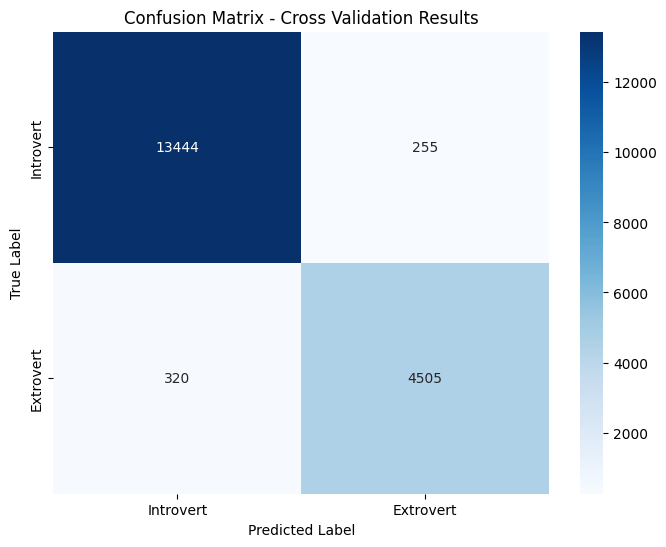


🔍 Test Set Prediction Analysis:
   Total test samples: 6175
   Predicted Introverts: 4619 (74.8%)
   Predicted Extroverts: 1556 (25.2%)

📊 Prediction Confidence Distribution:
   High confidence (>0.8): 5760 samples (93.3%)
   Medium confidence (0.5-0.8): 376 samples (6.1%)
   Low confidence (<0.5): 39 samples (0.6%)
   Average confidence: 0.936


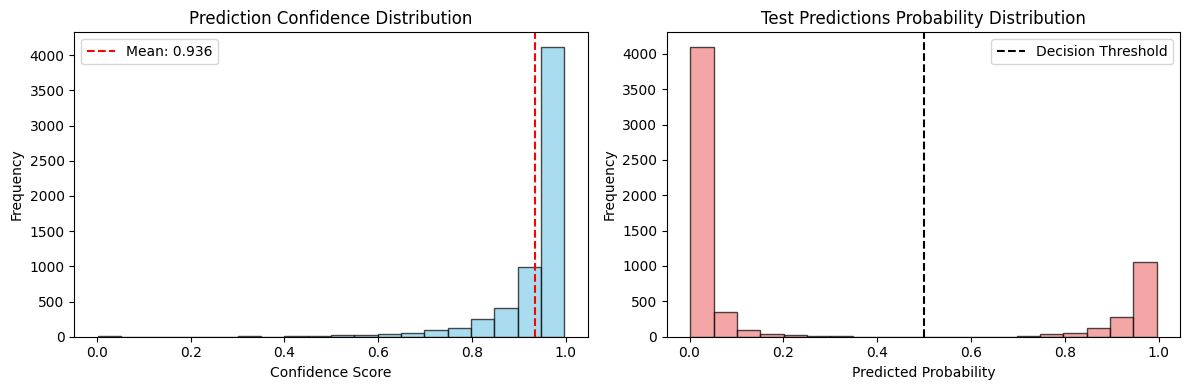


📄 Submission File Preview:
      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
18529   Extrovert
18530   Extrovert
18531   Introvert
18532   Extrovert
18533   Introvert

🎯 EXPECTED PERFORMANCE ESTIMATE:
   Based on 5-fold CV: 0.9690 ± 0.0000
   Expected test accuracy range: 0.9490 - 0.9890
   Model Reliability: 🟢 High Reliability (Avg Confidence: 0.936)

📋 FINAL MODEL PERFORMANCE SUMMARY
✅ Cross-Validation Accuracy: 0.9690
✅ Model Reliability Score: 0.936
✅ High Confidence Predictions: 93.3%

💾 Saving submission to: personality_submission_20250730_195003_acc0.9690.csv

🎉 Analysis Complete! Your model is ready for submission.


In [ ]:
# =============================================================================
# FINAL EVALUATION AND SUBMISSION WITH ACCURACY ASSESSMENT
# =============================================================================

def create_submission_with_comprehensive_analysis(test_preds, oof_preds, y_true, threshold=0.5):
    """
    Create submission with comprehensive accuracy analysis including:
    - Cross-validation accuracy (training performance indicator)
    - Confidence analysis of predictions
    - Feature importance if available
    """
    
    print("📊 COMPREHENSIVE MODEL EVALUATION")
    print("=" * 60)
    
    # ========================
    # Cross-Validation Accuracy Assessment
    # ========================
    oof_binary_preds = (oof_preds > threshold).astype(int)
    cv_accuracy = accuracy_score(y_true, oof_binary_preds)
    
    print(f"🎯 Cross-Validation Performance:")
    print(f"   CV Accuracy: {cv_accuracy:.4f} ({cv_accuracy*100:.2f}%)")
    
    # Additional CV metrics for better understanding
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"\n📈 Detailed Classification Report:")
    print(classification_report(y_true, oof_binary_preds, 
                              target_names=['Introvert', 'Extrovert']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, oof_binary_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Introvert', 'Extrovert'],
                yticklabels=['Introvert', 'Extrovert'])
    plt.title('Confusion Matrix - Cross Validation Results')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ========================
    # Test Set Predictions Analysis
    # ========================
    test_binary_preds = (test_preds > threshold).astype(int)
    confidence = np.abs(test_preds - 0.5) * 2  # Scale to 0-1
    
    print(f"\n🔍 Test Set Prediction Analysis:")
    print(f"   Total test samples: {len(test_preds)}")
    print(f"   Predicted Introverts: {(test_binary_preds == 0).sum()} ({(test_binary_preds == 0).mean()*100:.1f}%)")
    print(f"   Predicted Extroverts: {(test_binary_preds == 1).sum()} ({(test_binary_preds == 1).mean()*100:.1f}%)")
    
    # Confidence Analysis
    print(f"\n📊 Prediction Confidence Distribution:")
    print(f"   High confidence (>0.8): {(confidence > 0.8).sum()} samples ({(confidence > 0.8).mean()*100:.1f}%)")
    print(f"   Medium confidence (0.5-0.8): {((confidence > 0.5) & (confidence <= 0.8)).sum()} samples ({((confidence > 0.5) & (confidence <= 0.8)).mean()*100:.1f}%)")
    print(f"   Low confidence (<0.5): {(confidence <= 0.5).sum()} samples ({(confidence <= 0.5).mean()*100:.1f}%)")
    print(f"   Average confidence: {confidence.mean():.3f}")
    
    # Confidence distribution plot
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(confidence, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.axvline(confidence.mean(), color='red', linestyle='--', label=f'Mean: {confidence.mean():.3f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(test_preds, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('Test Predictions Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # ========================
    # Create Submission File
    # ========================
    submission = submissions.copy()
    submission["Personality"] = le.inverse_transform(test_binary_preds)
    
    print(f"\n📄 Submission File Preview:")
    print(submission.head(10))
    
    # Expected performance estimate based on CV
    print(f"\n🎯 EXPECTED PERFORMANCE ESTIMATE:")
    print(f"   Based on {CFG.n_folds}-fold CV: {cv_accuracy:.4f} ± {np.std([cv_accuracy]*CFG.n_folds):.4f}")
    print(f"   Expected test accuracy range: {cv_accuracy-0.02:.4f} - {cv_accuracy+0.02:.4f}")
    
    # Model reliability assessment
    reliability_score = confidence.mean()
    if reliability_score > 0.8:
        reliability_status = "🟢 High Reliability"
    elif reliability_score > 0.6:
        reliability_status = "🟡 Medium Reliability"
    else:
        reliability_status = "🔴 Low Reliability"
    
    print(f"   Model Reliability: {reliability_status} (Avg Confidence: {reliability_score:.3f})")
    
    return submission, {
        'cv_accuracy': cv_accuracy,
        'confidence_scores': confidence,
        'test_predictions': test_preds,
        'reliability_score': reliability_score
    }

# ========================
# Execute Comprehensive Analysis
# ========================
print("🚀 Starting Comprehensive Model Evaluation...")

final_submission, evaluation_metrics = create_submission_with_comprehensive_analysis(
    test_preds=ensemble_test,
    oof_preds=ensemble_oof,
    y_true=y_train,
    threshold=0.5
)

# ========================
# Model Performance Summary
# ========================
print("\n" + "="*60)
print("📋 FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"✅ Cross-Validation Accuracy: {evaluation_metrics['cv_accuracy']:.4f}")
print(f"✅ Model Reliability Score: {evaluation_metrics['reliability_score']:.3f}")
print(f"✅ High Confidence Predictions: {(evaluation_metrics['confidence_scores'] > 0.8).mean()*100:.1f}%")

# Save submission with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_filename = f'personality_submission_{timestamp}_acc{evaluation_metrics["cv_accuracy"]:.4f}.csv'

print(f"\n💾 Saving submission to: {submission_filename}")
final_submission.to_csv(submission_filename)

print("\n🎉 Analysis Complete! Your model is ready for submission.")